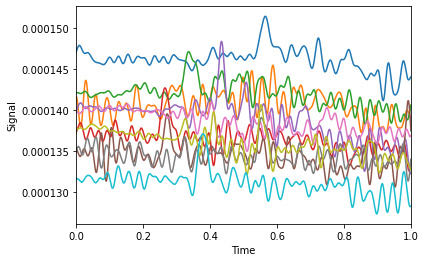

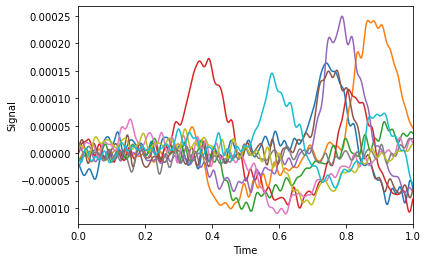

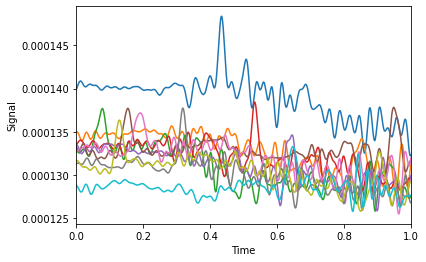

In [1]:
import numpy as np
import scipy.io as sio
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from eeg_emg_load import load_emg_eeg_data, butter_bandpass_filter, epoch, plot_epochs
from model_utils import train_LDA, train_RFs, train_SVM, train_HTNet, balance_data  #fold_split_

# Load in the EEG and EMG data

In [3]:

path = 'G:/.shortcut-targets-by-id/16bjLJ-x3DCMytjvubbbvXEirA9t2l2q-/FinalProjectData';

eeg_folder = 'EEG'
eeg_file = 'EEG_session1_sub1_multigrasp_realMove.mat'

emg_folder = 'EMG_ConvertedData'
emg_file = 'EMG_session1_sub1_multigrasp_realMove.mat'

# Load data in
emg_data, emg_fs, emg_event_times, emg_grasp_labels, emg_grasp_names = load_emg_eeg_data(os.path.join(path,emg_folder, emg_file));
eeg_data, eeg_fs, eeg_event_times, eeg_grasp_labels, eeg_grasp_names = load_emg_eeg_data(os.path.join(path,eeg_folder, eeg_file));

In [4]:
# Apply butter bandpass filter
emg_data = butter_bandpass_filter(emg_data, 8, 30, emg_fs, order=5)
eeg_data = butter_bandpass_filter(eeg_data, 8, 30, emg_fs, order=5)

In [5]:
# Break into epochs
emg_epochs = epoch(emg_data,emg_event_times, emg_fs, 1);
eeg_epochs = epoch(eeg_data,eeg_event_times, eeg_fs, 1);#

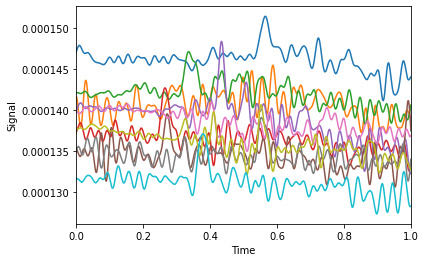

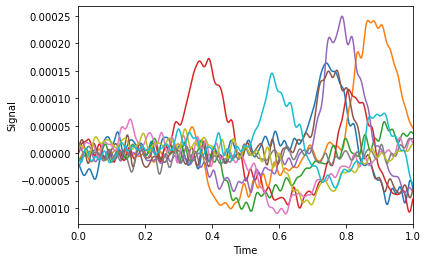

In [6]:
# Plot epochs
plot_epochs(emg_epochs, emg_fs, 1, 10) # First number is number of channels, Second number is number of epochs
plot_epochs(eeg_epochs, eeg_fs, 1, 10) # First number is number of channels, Second number is number of epochs

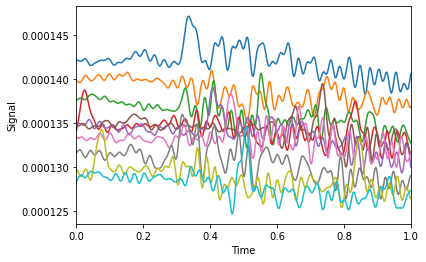

In [7]:
" Now let's see if we can plot the subset for a specified label"
plot_epochs(emg_epochs[:,:,emg_grasp_labels == 3], emg_fs, 1, 10)

In [8]:
# samples, channels, num events
emg_epochs.shape

(2500, 7, 300)

In [9]:
eeg_grasp_names = [i[0] for i in eeg_grasp_names]
eeg_grasp_names

['Cylindrical', 'Spherical', 'Lumbrical', 'Rest']

In [10]:
# Check to see if the EMG and EEG grasp labels match
np.all(emg_grasp_labels == eeg_grasp_labels)

True

In [11]:
trimmed_grasp_labels, trimmed_emg_epochs, trimmed_eeg_epochs = balance_data(emg_grasp_labels, emg_epochs, eeg_epochs)

[2. 3. 1. 4. 3. 3. 2. 4. 3. 4. 2. 2. 1. 4. 3. 3. 1. 1. 4. 2. 4. 1. 3. 4.
 2. 4. 1. 4. 1. 2. 4. 2. 4. 1. 1. 4. 3. 3. 2. 3. 4. 1. 4. 3. 3. 4. 3. 2.
 1. 3. 4. 2. 2. 4. 1. 4. 3. 3. 4. 1. 1. 1. 4. 2. 1. 4. 2. 1. 4. 3. 1. 3.
 4. 1. 3. 3. 1. 3. 3. 4. 3. 2. 4. 1. 4. 2. 4. 1. 1. 4. 2. 2. 3. 1. 4. 1.
 1. 4. 2. 2. 3. 1. 1. 4. 1. 2. 4. 2. 4. 2. 4. 3. 4. 1. 4. 3. 2. 2. 1. 3.
 3. 4. 2. 1. 3. 3. 4. 1. 4. 3. 4. 3. 2. 3. 2. 3. 1. 2. 3. 2. 2. 2. 1. 1.
 1. 4. 2. 4. 2. 3. 3. 3. 1. 1. 1. 3. 2. 2. 4. 1. 1. 1. 2. 2. 4. 2. 3. 3.
 3. 2. 3. 4. 2. 2. 1. 1. 3. 4. 2. 2. 1. 4. 2. 4. 3. 2. 2. 3. 4. 2. 1. 2.
 2. 1. 3. 1. 3. 1. 3. 4.]
(2500, 7, 200)
(2500, 7, 200)
(array([1., 2., 3., 4.]), array([50, 50, 50, 50], dtype=int64))


In [12]:

x_train = trimmed_emg_epochs[:,:,0:50]
x_test = trimmed_emg_epochs[:,:,50:trimmed_grasp_labels.shape[0]]
y_train = trimmed_grasp_labels[0:50]
y_test = trimmed_grasp_labels[50:trimmed_grasp_labels.shape[0]]
# Reshape x_train y swapping axes
x_train = np.swapaxes(x_train, 0, 2)
x_test = np.swapaxes(x_test, 0, 2)
# X needs to be of shape (n_epochs, n_channels, n_times)
# Y needs to be shape (n_epochs,)

y_train

array([2., 3., 1., 4., 3., 3., 2., 4., 3., 4., 2., 2., 1., 4., 3., 3., 1.,
       1., 4., 2., 4., 1., 3., 4., 2., 4., 1., 4., 1., 2., 4., 2., 4., 1.,
       1., 4., 3., 3., 2., 3., 4., 1., 4., 3., 3., 4., 3., 2., 1., 3.])

In [13]:
from mne.decoding import CSP # Import CSP
#https://mne.tools/stable/generated/mne.decoding.CSP.html#mne.decoding.CSP.fit
                    
csp = CSP(n_components = 4, transform_into = 'csp_space') # Initate CSP
csp.fit(x_train,y_train) # Fit CSP using training data
params = csp.get_params # Get parameters in case we want to see them
# plot CSP patterns estimated on full data for visualization
X_train = csp.transform(x_train) # Transform the training set
X_test = csp.transform(x_test) # Transform the test set

Computing rank from data with rank=None
    Using tolerance 0.22 (2.2e-16 eps * 7 dim * 1.4e+14  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.21 (2.2e-16 eps * 7 dim * 1.4e+14  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.25 (2.2e-16 eps * 7 dim * 1.6e+14  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.25 (2.2e-16 eps * 7 dim * 1.6e+14  max singular value)
    Estimated rank (mag): 7
   

In [51]:
def feature_extract_csp(x_train,y_train, x_test, n_components):
    """
    Input: 
    
    x_train: array (n_epochs, n_channels, n_times)
            Array with the trainining data
            
    y_train: array (n_epochs,)
            Array with the event labels
            
    x_test:  array (n_epochs, n_channels, n_times)
            Array with the test data
            
    n_componenets: Integer
            Number of components to calculate. 
    """
    from mne.decoding import CSP # Import CSP
    #https://mne.tools/stable/generated/mne.decoding.CSP.html#mne.decoding.CSP.fit         
    csp = CSP(n_components = n_components, transform_into = 'csp_space') # Initate CSP
    csp.fit(x_train,y_train) # Fit CSP using training data
    params = csp.get_params # Get parameters in case we want to see them
    # plot CSP patterns estimated on full data for visualization
    X_train = csp.transform(x_train) # Transform the training set
    X_test = csp.transform(x_test) # Transform the test set
    
    return X_train, X_test

In [53]:
X_train, X_test = feature_extract_csp(x_train, y_train, x_test,4)

Computing rank from data with rank=None
    Using tolerance 0.23 (2.2e-16 eps * 7 dim * 1.5e+14  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.23 (2.2e-16 eps * 7 dim * 1.5e+14  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.25 (2.2e-16 eps * 7 dim * 1.6e+14  max singular value)
    Estimated rank (mag): 7
    MAG: rank 7 computed from 7 data channels with 0 projectors
Reducing data rank from 7 -> 7
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.22 (2.2e-16 eps * 7 dim * 1.4e+14  max singular value)
    Estimated rank (mag): 7
   

# Plot the CSP

In [184]:
np.shape(X_train)
emg_grasp_names[trimmed_grasp_labels[0:2].astype(int)][0].astype(str)

array(['Lumbrical'], dtype='<U9')

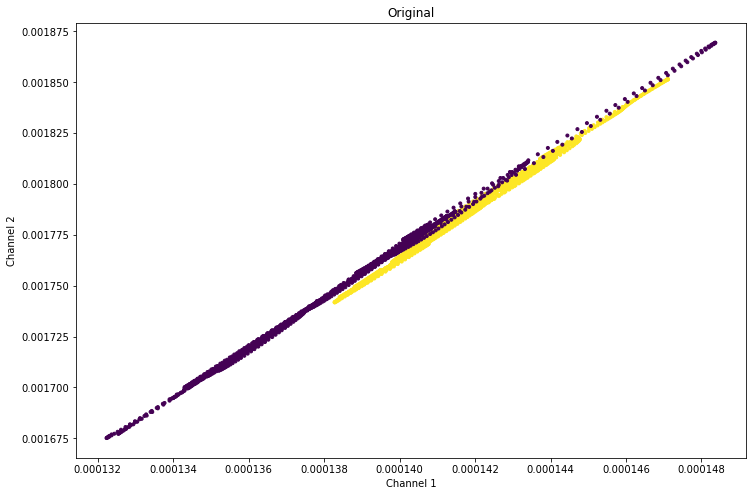

In [198]:
# Let's plot the first channel against the second channel
cdata = np.multiply(np.reshape(y_train[1:3], [2,1]),np.ones([2,x_train.shape[2]]))
plt.figure(figsize=(12,8))
plt.scatter(x_train[1:3,0,:],x_train[1:3,1,:],
            c=cdata, marker = '.')
plt.xlabel('Channel 1')
plt.ylabel('Channel 2')
plt.title('Original')
plt.show()

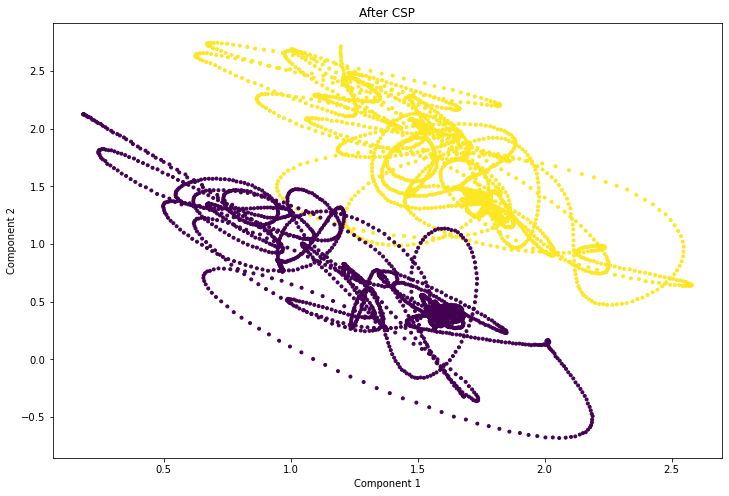

In [199]:
# Let's plot the first feature against the second
cdata = np.multiply(np.reshape(y_train[1:3], [2,1]),np.ones([2,X_train.shape[2]]))
plt.figure(figsize=(12,8))
plt.scatter(X_train[1:3,0,:],X_train[1:3,1,:], 
            c = cdata, marker = '.')
plt.xlabel('Component 1') # Component 1
plt.ylabel('Component 2') # Component 2
plt.title('After CSP')
plt.show()

In [191]:
# Calculate the log(var) of the trials
def logvar(trials):
    '''
    Calculate the log-var of each channel.
    
    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEG signal.
        
    Returns
    -------
    logvar - 2d-array (channels x trials)
        For each channel the logvar of the signal
        
    From: https://github.com/wmvanvliet/neuroscience_tutorials/blob/master/eeg-bci/3.%20Imagined%20movement.ipynb
    '''
    return np.log(np.var(trials, axis=1))


In [192]:
def plot_logvar(trials, nchannels):
    '''
    Plots the log-var of each channel/component.
    arguments:
        trials - Dictionary containing the trials (log-vars x trials) for 2 classes.
        nchannels - number of channels
        From: https://github.com/wmvanvliet/neuroscience_tutorials/blob/master/eeg-bci/3.%20Imagined%20movement.ipynb
    '''
    plt.figure(figsize=(12,5))
    
    x0 = np.arange(nchannels)
    x1 = np.arange(nchannels) + 0.4

    y0 = np.mean(trials[0], axis=1)
    y1 = np.mean(trials[1], axis=1)
    
    plt.bar(x0, y0, width=0.5, color='b')
    plt.bar(x1, y1, width=0.4, color='r')

    
    plt.xlim(-0.5, nchannels+0.5)

    plt.gca().yaxis.grid(True)
    plt.title('log-var of each channel/component')
    plt.xlabel('channels/components')
    plt.ylabel('log-var')

(7, 2500, 10)
(7, 2500, 11)


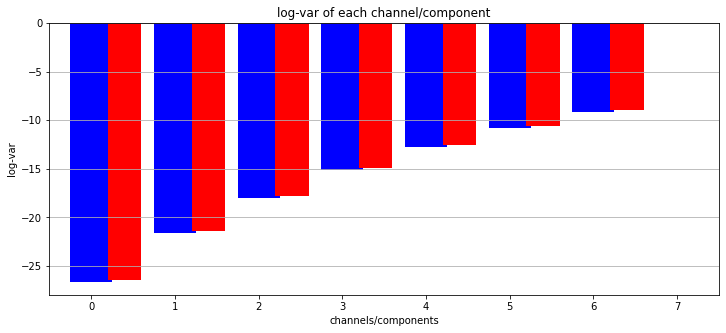

In [193]:
# Let's plot the log-var before CSP
x_train.shape
log_chs = np.swapaxes(x_train, 0,1)
log_chs = np.swapaxes(log_chs, 1, 2)
log_chs.shape
ch1 = log_chs[:,:,y_train == 2]
ch2 = log_chs[:,:,y_train == 1]
print(ch1.shape)
print(ch2.shape)
ch2 = ch2[:,:,0:10]
# Apply the function
trials_logvar = {0: logvar(ch1),
                 1: logvar(ch2)}
plot_logvar(trials_logvar, 7)

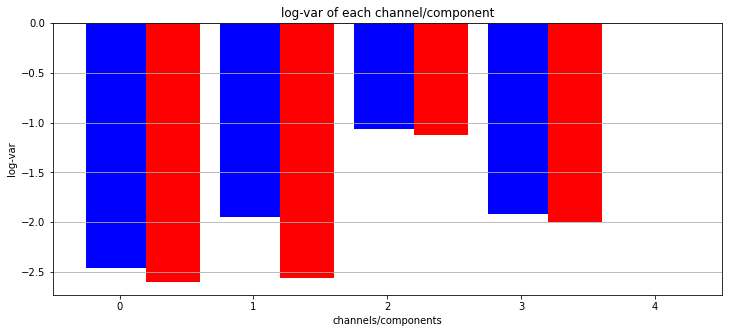

In [195]:
# Now, let's plot the log-var after CSP
log_chs = np.swapaxes(X_train, 0,1)
log_chs = np.swapaxes(log_chs, 1, 2)
ch1 = log_chs[:,:,y_train == 2]
ch2 = log_chs[:,:,y_train == 1]
ch2 = ch2[:,:,0:10]
# Apply the function
trials_logvar1 = {0: logvar(ch1),
                1: logvar(ch2)}
plot_logvar(trials_logvar1,4)

(150, 4)